# Your Classifier is Secretly an Energy-based Model

[Grathwohl et al. (2020)](https://openreview.net/forum?id=Hkxzx0NtDB)

Objective / initial thoughts:

 * Train an energy-based model to generate hand-written digits (not MNIST, but the smaller sklearn dataset).
 * The model should "look like" a classifier.
 * Unsupervised training: the model should output a low energy score for e.g. zeros. $p_\theta(x)$ should be low.
 * Then we can sample zeros from the model using Langevin dynamics.

**Eq. 1** from the paper: $\displaystyle p_\theta(x)=\frac{\exp(-E_\theta(x))}{Z(\theta)}$

 * We want to maximize ${\displaystyle\log p_\theta(\mathcal{D})=\log\prod_{x\in\mathcal{D}}p_\theta(x)}$, which is the probability of the data according to our model
 * We model the energy function $E$ in $\displaystyle p_\theta(x)=\frac{\exp(-E_\theta(x))}{Z(\theta)}$ using a network. It outputs only one scalar.
 * **Eq. 2** is the gradient of $p(x)$ wrt. the parameters.
   * The right side can be computed "as usual" (forward pass and `(-net(x)).backward()` call – there is no loss).
   * The left side requires (a) sampling an $x'$ from the current model and (b) computing `net(x_prime).backward()`. Difficult is (a).

**Eq. 3** is a possible implementation of (a). Sample an $x_0$ (set `requires_grad=True`) and 

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import torch
from torch import Tensor
from torchsummary import summary
from tqdm import tqdm
from typing import *

In [2]:
dataset = sklearn.datasets.load_digits()
data_np, labels_np = dataset['data'], dataset['target']
data_np = data_np[labels_np <= 0]
del labels_np

data = torch.from_numpy(data_np.astype(np.float32))
data = data / data.max()  # Normalize between [0, 1]
IMG_DIM = data.shape[1]
data.shape, data.dtype

(torch.Size([178, 64]), torch.float32)

In [3]:
def imshow(x: Tensor) -> None:
    plt.imshow(x.reshape((8, 8)));

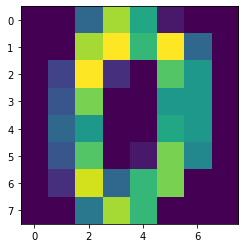

In [4]:
imshow(data[0])

### Model Definition

In [55]:
class Energy(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        activation_fn = torch.nn.SiLU()

        self.convs = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3)),
            activation_fn,
            torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3)),
            activation_fn,
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(4, 4)),
            activation_fn,
        )

        self.linear = torch.nn.Linear(in_features=16, out_features=1)
    
    def forward(self, x: Tensor) -> Tensor:
        x = x.view(-1, 1, 8, 8)
        x = self.convs(x)
        x = x.view(-1, x.shape[1])
        return self.linear(x)


class EnergyMLP(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
        activation_fn = torch.nn.SiLU()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(64, 16),
            activation_fn,
            torch.nn.Linear(16, 8),
            activation_fn,
            torch.nn.Linear(8, 1),
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x.view(-1, 64))

In [56]:
summary(Energy(), data[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 4, 6, 6]              40
              SiLU-2              [-1, 4, 6, 6]               0
            Conv2d-3              [-1, 8, 4, 4]             296
              SiLU-4              [-1, 8, 4, 4]               0
            Conv2d-5             [-1, 16, 1, 1]           2,064
              SiLU-6             [-1, 16, 1, 1]               0
            Linear-7                    [-1, 1]              17
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Inference

**Eq. 3**. This is also needed for $x'$ in the training loop in Eq. 2.

In [57]:
ALPHA_START = 1e-1
# This is tricky because we don't want to decay during the Langevin dynamics phase.
ALPHA_END = 1e-3

WARMUP_STEPS = 100
LANGEVIN_SKIPS = 100

In [58]:
def generate(
    energy_fn: Callable[[Tensor], Tensor], num_samples: int, langevin_skips=LANGEVIN_SKIPS
) -> Iterable[np.ndarray]:
    num_langevin_steps = num_samples * langevin_skips
    num_total_steps = num_langevin_steps + WARMUP_STEPS
    
    x_0 = torch.rand(size=(8, 8))  # same range as the data distribution, [0, 1]
    x_0.requires_grad = True
    alpha_scheduled = np.linspace(ALPHA_START, ALPHA_END, num=num_total_steps)

    x_i = x_0
    for steps in range(num_total_steps):
        eps = torch.randn(x_0.shape) * alpha_scheduled[steps]
        d_energy_dx = torch.autograd.grad(outputs=energy_fn(x_i), inputs=x_i)[0]
        x_i = x_i - alpha_scheduled[steps] / 2 * d_energy_dx + eps
        
        in_langevin_phase = steps >= WARMUP_STEPS
        if in_langevin_phase:
            steps_in_langevin_phase = steps - WARMUP_STEPS
            if steps_in_langevin_phase % langevin_skips == 0:
                yield x_i.detach()

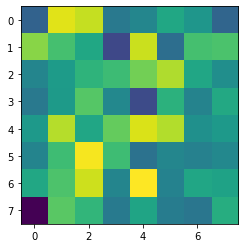

In [59]:
energy = Energy()
for generated_img in generate(energy, num_samples=1):
    plt.figure()
    imshow(generated_img.numpy());

### Training Loop

In [60]:
NUM_STEPS = 100
LEARNING_RATE = np.linspace(1e-1, 1e-3, NUM_STEPS)
BATCH_SIZE = 40
MC_SAMPLES = 10
SAMPLER_RESTARTS = 40

In [65]:
energy = Energy()
opt = torch.optim.Adam(params=energy.parameters(), lr=LEARNING_RATE[0])
log = defaultdict(list)

for steps in tqdm(range(NUM_STEPS)):
    opt.param_groups[0]['lr'] = LEARNING_RATE[steps]
    opt.zero_grad()
    
    # left side of Eq. 1 (MCMC)
    x_primes = torch.stack([x for x in generate(energy, MC_SAMPLES) for _ in range(SAMPLER_RESTARTS)])
    logits_mcmc = torch.mean(energy(x_primes))
    log['logits_mcmc'].append(logits_mcmc.detach().numpy())
    
    batch = data[np.random.randint(0, len(data), size=BATCH_SIZE)]
    # right side of Eq. 2 ("normal" model training)
    logits_data = torch.mean(energy(batch))
    log['logits_data'].append(logits_data.detach().numpy())
    
    log_px = (logits_mcmc - logits_data)  # possibly an inaccurate name
    
    (-log_px).backward()
    
    opt.step()

100%|██████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


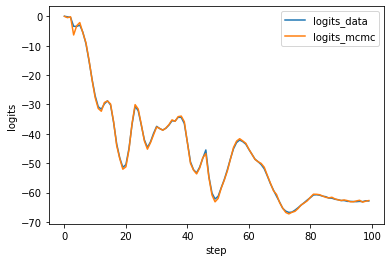

In [66]:
plt.plot(log['logits_data'], label='logits_data')
plt.plot(log['logits_mcmc'], label='logits_mcmc')
plt.xlabel('step')
plt.ylabel('logits')
plt.legend();

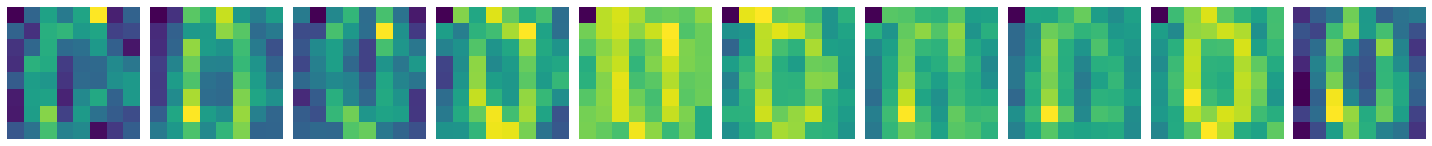

In [67]:
samples = list(generate(energy, num_samples=10, langevin_skips=1500))
fig, ax = plt.subplots(1, len(samples), figsize=(20, 8))
ax = ax.flatten()

for i, x_sample in enumerate(samples):
    ax[i].imshow(x_sample.numpy())
    ax[i].axis('off')

plt.tight_layout()